In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import OrderedDict
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

## Датасеты
<a href=http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz>Датасет с отзывами на музыкальные инструменты</a><br>
<a href=http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Automotive_5.json.gz>Датасет с отзывами на автомобили</a><br>
<a href=http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz>Датасет с отзывами на фильмы</a><br>
<a href=http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz>Датасет с отзывами на электронику</a><br>

Чтобы все работало без редактирования, данные должны лежать в распакованном виде в ../data/

In [2]:
data_path = {
    "music": os.path.join("..", "data", "Musical_Instruments_5.json"),
    "auto":  os.path.join("..", "data", "Automotive_5.json"),
    "movies":    os.path.join("..", "data", "Movies_and_TV_5.json"),
    "electr":    os.path.join("..", "data", "Electronics_5.json"),
}

In [3]:
def load_json(path: str, columns=["helpful", "reviewText", "summary", "overall"]) -> pd.DataFrame:
    '''
    Loads Amazon Review Dataset from the specified json file.
    Only includes fields, passed in 'columns' argument.
    Returns: DataFrame
    '''
    if not os.path.exists(path):
        raise FileExistsError("'%s' does not exists!" % path)
    with open(path) as fp:
        lines = fp.readlines()
    lines = list(map(lambda s: json.loads(s, object_pairs_hook=OrderedDict), lines))
    return pd.DataFrame(lines).loc[:, columns]

def raw_data_generator(path: str, columns=["helpful", "reviewText", "summary", "overall"]) -> OrderedDict:
    if not os.path.exists(path):
        raise FileExistsError("'%s' does not exists!" % path)
    with open(path) as fp:
        for line in fp:
            parsed = json.loads(line, object_pairs_hook=OrderedDict)
            yield {key: parsed[key] for key in columns}
            
def batch_generator(path: str, columns=["helpful", "reviewText", "summary", "overall"], max_batch_size=500):
    lines = []
    for obj in raw_data_generator(path, columns):
        lines.append(obj)
        if len(lines) == max_batch_size:
            yield pd.DataFrame(lines)
            lines = []
    yield pd.DataFrame(lines)

def review_len(data: pd.DataFrame) -> np.array:
    '''
    Returns the list of reviews' lengths
    '''
    return np.array(list(map(lambda a: len(a.split()), data["reviewText"])))

In [5]:
mus_df = load_json(data_path["music"])

KeyboardInterrupt: 

In [ ]:
mus_df.head()

90.183315466328821

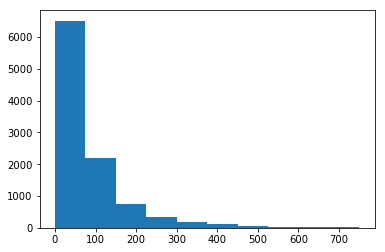

In [47]:
lens = review_len(mus_df)
plt.hist(lens, range=(0, 750))
np.mean(lens)

## Предобработка
* Перевод в нижний регистр
* Удаление ненужных символов
* Удаление стоп-слов
* Удаление токенов короче 3 символов

Без лемматизации и стемминга

In [4]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
import re

class Preprocessor:
    
    def __init__(self):
        self.stopwords = stopwords.words("english")
        self.to_drop = self.stopwords + list(punctuation) + list("0123456789“")
        
    def preprocess(self, text: str) -> str:
        # Lowercase conversion
        new_text = text.lower()
        new_text = re.sub("\.(?=\S)", " . ", new_text)
        tokens = word_tokenize(new_text)
        tokens = list(filter(lambda a: a not in self.to_drop and len(a) >= 3, tokens))
        return " ".join(tokens)
        
    

In [5]:
def test_pp():
    test_str = "One way would be to split the document into words by white space \
    (as in “2. Split by Whitespace“), then use string translation to replace all \
    punctuation with nothing (e.g. remove it)."
    p = Preprocessor()
    return p.preprocess(test_str)

test_pp()

'one way would split document words white space split whitespace use string translation replace punctuation nothing remove'

In [5]:
# Preprocessing the dataframe
def preprocess_df(df: pd.DataFrame, merge_summary=False) -> pd.DataFrame:
    """
    If 'merge_summary' is True, merges 'Summary' column into 'reviewText'
    """
    p = Preprocessor()
    reviews = list(map(p.preprocess, df["reviewText"]))
    summaries = list(map(p.preprocess, df["summary"]))
    new_df = df.copy()
    new_df["reviewText"] = reviews
    new_df["summary"] = summaries
    if merge_summary:
        new_df["reviewText"] += " " + new_df["summary"]
    return new_df

# preprocess_df(mus_df[:5])["reviewText"].values

In [102]:
# Now reviewText contains summary as well
# We can work only with this column
mus_df = preprocess_df(mus_df, merge_summary=True)

In [112]:
mus_df.tail()

,helpful,reviewText,summary,overall
10256,"[0, 0]",great expected thank five stars,five stars,5.0
10257,"[0, 0]",'ve thinking trying nanoweb strings bit put hi...,long life players good economic choice,5.0
10258,"[0, 0]",tried coated strings past including elixirs ne...,good coated,4.0
10259,"[0, 0]",well made elixir developed taylor guitars stri...,taylor made,4.0
10260,"[0, 0]",strings really quite good would n't call perfe...,strings really quite good would n't call perfect,4.0


Теперь все то же самое проделываем с датасетом из домена автомобилей

85.348752014848827

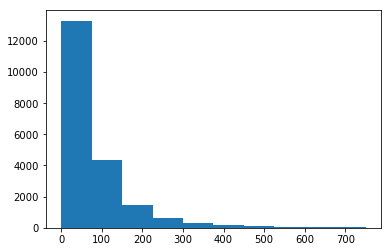

In [111]:
auto_df = load_json(data_path["auto"])
lens = review_len(auto_df)
plt.hist(lens, range=(0, 750))
np.mean(lens)

In [114]:
auto_df = preprocess_df(auto_df, merge_summary=True)

## Создание векторной модели
Для word embedding используется word2vec

In [6]:
from gensim.models import Word2Vec

def train_w2v_model(dfs: list) -> Word2Vec:
    data = []
    for df in dfs:
        data += list(map(str.split, df["reviewText"].values))
    model = Word2Vec(sentences=data, size=128, min_count=3)
    model.train(data, total_examples=len(data), epochs=50)
    return model

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [179]:
w2v = train_w2v_model([mus_df, auto_df])

In [180]:
mus_df.shape, auto_df.shape

((10261, 4), (20473, 4))

In [181]:
w2v.wv.vectors.shape

(16894, 128)

In [182]:
w2v.save("./mus_auto.w2v")

Сохраним векторы, чтобы в будущем работать только с ними

In [7]:
def create_vectors(df: pd.DataFrame, model: Word2Vec) -> pd.DataFrame:
    res = {
        "vectors": [],
        "overall": [],
    }
    for i in df.index:
        tokens = df.loc[i, "reviewText"].split()
        vec_lst = []
        for word in tokens:
            try:
                vec_lst.append(list(model.wv.get_vector(word)))
            except KeyError:
                pass
        res["vectors"].append(vec_lst)
        res["overall"].append(df.loc[i, "overall"])
    # Also adding the target variable
    return pd.DataFrame(res)

In [219]:
mus_vectors = create_vectors(mus_df, w2v)
mus_vectors.to_csv("../data/mus_vectors.csv", sep="\t", index=False)

In [220]:
auto_vectors = create_vectors(auto_df, w2v)
auto_vectors.to_csv("../data/auto_vectors.csv", sep="\t", index=False)

### Датасеты Movies и Electronics
Для полной загрузки этих таблиц не хватает памяти, поэтому обработка построчная

Нужно два раза пройтись по текстам: первый раз, чтобы обучить модель w2v, а второй - чтобы создать векторы

In [8]:
def create_vectors_from_file(pp_file: str, 
                   vector_file: str, 
                   w2v_file: str, 
                   batch_size=1000, 
                   vector_size=128):
    w2v = Word2Vec.load(w2v_file)
    vector_fp = open(vector_file, "w")
    header = True
    for num, batch in enumerate(pd.read_csv(pp_file, sep="\t", chunksize=batch_size)):
        clear_output(True)
        display("Creating vectors")
        display("Processing batch {}".format(num + 1))
        vector_batch = create_vectors(batch, w2v)
        vector_batch.to_csv(vector_fp, header=header, sep="\t", index=False)
        header = False

In [9]:
def process_file(raw_data_file: str,
                 vector_file: str,
                 pp_backup_file: str,
                 w2v_model_file: str,
                 create_w2v=False,
                 columns=["reviewText", "summary", "overall"], 
                 batch_size=1000,
                 vector_size=128,):
    data_gen = batch_generator(raw_data_file, columns, batch_size)
    if create_w2v:
        w2v = Word2Vec(size=vector_size, min_count=3)
    else:
        w2v = Word2Vec.load(w2v_model_file)
    header = True
    pp_file = open(pp_backup_file, "w")
    # Первый проход
    for num, batch in enumerate(data_gen):
        # Предобработка
        clear_output(True)
        display("Preprocessing and w2v training")
        display("Processing batch {}".format(num + 1))
        pp_batch = preprocess_df(batch, merge_summary=True)
        pp_batch.to_csv(pp_file, header=header, sep="\t", index=False)
        if header and create_w2v:
            # Признак первого батча 
            header = False
            w2v.build_vocab(pp_batch["reviewText"].values, update=False)
            w2v.train(pp_batch["reviewText"].values, total_examples=len(pp_batch["reviewText"]), epochs=20)
        # Обучение модели w2v
        w2v.build_vocab(pp_batch["reviewText"].values, update=True)
        w2v.train(pp_batch["reviewText"].values, total_examples=len(pp_batch["reviewText"]), epochs=20)
    w2v.save(w2v_model_file)
    # Второй проход
#     vector_file = open(vector_file, "w")
#     header = True
#     for num, batch in enumerate(pd.read_csv(pp_backup_file, sep="\t", chunksize=batch_size)):
#         clear_output(True)
#         display("Creating vectors")
#         display("Processing batch {}".format(num + 1))
#         vector_batch = create_vectors(batch, w2v)
#         vector_batch.to_csv(vector_file, header=header, sep="\t", index=False)
        

In [10]:
columns = ["reviewText", "summary", "overall"]
batch_size = 1000
vector_size = 128
w2v_file = "./w2v_movies_electr.model"

electr_pp_file = os.path.join("..", "data", "electr_pp.csv")
movies_pp_file = os.path.join("..", "data", "movies_pp.csv")

electr_vec_file = os.path.join("..", "data", "electr_vectors.csv")
movies_vec_file = os.path.join("..", "data", "electr_vectors.csv")

Предобработка и обучение w2v

In [13]:
%%time
process_file(raw_data_file=data_path["electr"], 
             vector_file=electr_vec_file, 
             pp_backup_file=electr_pp_file,
             w2v_model_file=w2v_file,
             create_w2v=True,
             columns=columns, 
             batch_size=batch_size, 
             vector_size=vector_size)

'Preprocessing and w2v training'

'Processing batch 1690'

Wall time: 1h 37min 26s


In [11]:
%%time
process_file(raw_data_file=data_path["movies"], 
             vector_file=movies_vec_file, 
             pp_backup_file=movies_pp_file,
             w2v_model_file=w2v_file,
             create_w2v=False,
             columns=columns, 
             batch_size=batch_size, 
             vector_size=vector_size,) 


'Preprocessing and w2v training'

'Processing batch 1698'

Wall time: 2h 18min 26s


Создание векторов

In [12]:
%%time
create_vectors_from_file(pp_file=electr_pp_file, 
               vector_file=electr_vec_file, 
               w2v_file=w2v_file, 
               batch_size=5000)

'Creating vectors'

'Processing batch 338'

Wall time: 2min 59s


In [13]:
%%time
create_vectors_from_file(pp_file=movies_pp_file, 
               vector_file=movies_vec_file, 
               w2v_file=w2v_file, 
               batch_size=5000)

'Creating vectors'

'Processing batch 340'

Wall time: 3min 48s
